# Tae-Seung Kim Module 8

col info here https://search.r-project.org/CRAN/refmans/creditmodel/html/lendingclub.html

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [200]:
old_data = pd.read_csv('fullacc_2007_2016.csv')

## Dates to dates

In [ ]:
old_data['issue_d'] = pd.to_datetime(old_data['issue_d'])

old_data['last_credit_pull_d'] = pd.to_datetime(old_data['last_credit_pull_d'])

old_data['earliest_cr_line'] = pd.to_datetime(old_data['earliest_cr_line'])

# make credit
old_data['credit_age'] = old_data['issue_d'] - old_data['earliest_cr_line']

# time since last inq
old_data['time_since_last_inq'] = old_data['issue_d'] - old_data['last_credit_pull_d']

# drop dates now
old_data = old_data.drop(['issue_d', 'last_credit_pull_d', 'earliest_cr_line'], axis=1)


C:\Users\tkkim\AppData\Local\Temp\ipykernel_46468\2090973682.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  old_data['last_credit_pull_d'] = pd.to_datetime(old_data['last_credit_pull_d'])
C:\Users\tkkim\AppData\Local\Temp\ipykernel_46468\2090973682.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  old_data['earliest_cr_line'] = pd.to_datetime(old_data['earliest_cr_line'])


## Remove useless columns

In [ ]:
old_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term',
       'credit_age', 'time_since_last_inq'],
      dtype='object', length=150)

In [ ]:
# drop member_id & URL and set index to id
# also drop title and desc as purpose is more useful and URL
old_data = old_data.drop(['member_id','url','desc', 'title'], axis=1)
old_data.set_index('id', inplace=True, drop=True)

# drop all the columns with sec_app in the name because they are all NaN
old_data = old_data.drop([col for col in old_data.columns if 'sec_app' in col], axis=1)

# drop all the hardship stuff because it's post loan issue
old_data = old_data.drop([col for col in old_data.columns if 'hardship' in col], axis=1)

# we'll do the same for settlement
old_data = old_data.drop([col for col in old_data.columns if 'settlement' in col], axis=1)

# join application stuff can also be dropped. ind/join can be flagged off application_type
old_data = old_data.drop([col for col in old_data.columns if 'joint' in col], axis=1)

# we can drop the last and next payment date columns because it's post loan issue
old_data = old_data.drop([col for col in old_data.columns if 'last_pymnt' in col or 'next_pymnt' in col], axis=1)

# drop zip because it is obfuscated and i'm sure that using it violates FHA, CRA or FLCA or something
old_data = old_data.drop('zip_code', axis=1)

# drop recoveries and fees because they're post default
old_data = old_data.drop(['recoveries', 'collection_recovery_fee'], axis=1)

# drop more post default cols and pymnt since we're predicting the probability of default on loan issue 
old_data = old_data.drop(["out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv",  "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "pymnt_plan"], axis=1)

# drop grade for now, high int rate means lower grade
old_data = old_data.drop(['grade', 'sub_grade'], axis=1)

# drop job title. Self reported titles are not useful. Industry would be useful but we don't have that
old_data = old_data.drop('emp_title', axis=1)

# drop policy code, only 1 value
old_data = old_data.drop('policy_code', axis=1)




## Make target 

In [ ]:
# create our target variable. 1 = defaulted, 0 = not
old_data['target'] = old_data['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Does not meet the credit policy. Status:Charged Off', 'Default'] else 0)

# drop loan status
old_data = old_data.drop(['loan_status'], axis=1)

In [ ]:
# first pass cleanse, check whats missing above 10%
tempdf = (old_data.isnull().sum()/old_data.shape[0]).reset_index()
tempdf[tempdf[0] > .10]

,index,0
18,mths_since_last_delinq,0.498673
19,mths_since_last_record,0.833584
29,mths_since_last_major_derog,0.737238
34,open_acc_6m,0.655242
35,open_act_il,0.655241
36,open_il_12m,0.655241
37,open_il_24m,0.655241
38,mths_since_rcnt_il,0.664516
39,total_bal_il,0.655241
40,il_util,0.700710


In [ ]:
# 2nd pass
# now looking at the above we can drop a lot of the these since they're duplicative
# first is open _acc and open_il
old_data = old_data.drop([col for col in old_data.columns if 'open' in col and col != 'open_acc'], axis=1)

# of all the inquiry time columns lets only keep last 6mo 
old_data = old_data.drop([col for col in old_data.columns if ('inq_' in col or '_inq' in col)and col != 'inq_last_6mths'], axis=1)

TypeError: 'DataFrame' object is not callable

In [197]:
old_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths

In [ ]:
tempdf = (old_data.isnull().sum()/old_data.shape[0]).reset_index()
tempdf[tempdf[0] > .10]

,index,0
18,mths_since_last_delinq,0.498673
19,mths_since_last_record,0.833584
29,mths_since_last_major_derog,0.737238
35,mths_since_rcnt_il,0.664516
36,total_bal_il,0.655241
37,il_util,0.700710
38,max_bal_bc,0.655241
39,all_util,0.655259
41,total_cu_tl,0.655242
51,mths_since_recent_bc_dlq,0.758849


In [ ]:
# now we can drop delinq time because we have delinq_2yrs
old_data = old_data.drop(['mths_since_last_delinq', 'mths_since_recent_revol_delinq', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog'], axis=1)

# we can also drop deferral/payment plan because we have settlement flag
old_data = old_data.drop(['payment_plan_start_date', 'deferral_term', 'orig_projected_additional_accrued_interest'], axis=1)

# for il we can just keep the total. also drop util
old_data = old_data.drop(['mths_since_rcnt_il', 'total_bal_il', 'il_util', 'all_util', 'total_cu_tl'], axis=1)

# we can clean up the max bal bc (bank card) columns as well and mths_since_last_record
old_data = old_data.drop(['max_bal_bc', 'mths_since_last_record'], axis=1)


In [174]:
old_data.columns

Index([], dtype='object')

In [172]:
# now we have a much cleaner dataset
tempdf = (old_data.isnull().sum()/old_data.shape[0]).reset_index()
tempdf[tempdf[0] > 0 ]

,index,0


## Imputation & Encoding


In [162]:
num_cols = old_data.select_dtypes(exclude='O') .columns.to_list()
str_cols = old_data.select_dtypes(include='O').columns.to_list()

len(num_cols)+ len(str_cols) == old_data.shape[1]

True

In [142]:
bigholder = []
for col in str_cols:
    small_holder = {}
    small_holder['col'] = col
    small_holder['unique'] = old_data[col].nunique()
    bigholder.append(small_holder)

str_uniq_df = pd.DataFrame(bigholder)
str_uniq_df

,col,unique
0,term,2
1,grade,7
2,sub_grade,35
3,emp_title,381900
4,emp_length,11
5,home_ownership,6
6,verification_status,3
7,loan_status,9
8,pymnt_plan,2
9,purpose,14


In [143]:
old_data.columns.to_list()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'dti',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'avg_cur_bal',
 'bc_util',
 'chargeoff_within_12_mths',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mt

In [144]:
old_data['sub_grade'].value_counts()

sub_grade
C1    84969
B4    84682
B3    82225
B5    80178
C2    78837
C3    75457
C4    74738
B2    72539
B1    69441
C5    64058
A5    61449
D1    51405
A4    49262
D2    44165
A1    41637
D3    37388
D4    35945
A3    33473
A2    33233
D5    29829
E1    25741
E2    22027
E3    19377
E4    16075
E5    13294
F1    10077
F2     7582
F3     6124
F4     4802
F5     3798
G1     2647
G2     2020
G3     1461
G4     1030
G5      882
Name: count, dtype: int64

In [145]:
old_data['zip_code']

KeyError: 'zip_code'

In [ ]:
# using kmeans impute
from sklearn.impute import KNNImputer




In [ ]:
num_cols.shape

(1321847, 63)

c:\Users\tkkim\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_axes.py:6831: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\tkkim\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_axes.py:6832: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

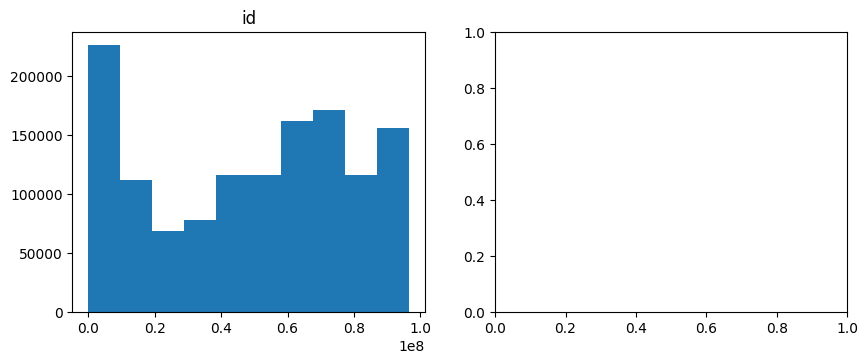

In [7]:
numerical_credit = old_data.select_dtypes(exclude='O') 

plt.figure(figsize=(10, 8))
k = 0
cols = numerical_credit.columns
for i, j in zip(range(len(cols)), cols):
    k +=1
    plt.subplot(2, 2, k)
    plt.hist(numerical_credit.iloc[:, i])
    plt.title(j)
